In [1]:
!pip install -q segmentation_models_pytorch
!pip install -qU wandb

In [2]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
from matplotlib.patches import Rectangle
from collections import defaultdict
import gc

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import albumentations as A

import rasterio
from joblib import Parallel, delayed

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import wandb
import segmentation_models_pytorch as smp


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Wandb

In [3]:
api_key = "1e3de8fb2c82895fac92caa7d02885c6b19ebb4f"
wandb.login(key=api_key)

wandb: Currently logged in as: Surya Reddy. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Configuration

In [4]:
class CFG:
    seed          = 101
    debug         = False 
    model_name    = 'Unet'
    backbone      = 'efficientnet-b1'
    train_bs      = 64
    valid_bs      = train_bs
    img_size      = [224, 224]
    epochs        = 25
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    fold          = 0
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
np.random.seed(CFG.seed)
random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed(CFG.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(CFG.seed)

# Meta Data

In [8]:
def read_and_prepare_data(mask_base_path):
    df = pd.read_csv(f"{mask_base_path}/train.csv")
    df["segmentation"] = df["segmentation"].notna()
    df["mask_path"] = df["mask_path"].str.replace("/png/", "/np").str.replace(".png", ".npy")
    return df

def get_segmentation_counts(df):
    df_unique = df.groupby("id").head(1).reset_index(drop=True)
    segmented_count, unsegmented_count = df_unique['segmentation'].value_counts()
    return segmented_count, unsegmented_count

mask_base_path = "/kaggle/input/uwmgi-mask-dataset"
df = read_and_prepare_data(mask_base_path)
segmented, unsegmented = get_segmentation_counts(df)

print(f"There are {segmented} segmented slices")
print(f"There are {unsegmented} unsegmented slices")

There are 24411 segmented slices
There are 14085 unsegmented slices


In [9]:
df.head(5)

,id,class,segmentation,case,day,slice,image_path,height,width,mask_path
0,case123_day20_slice_0001,large_bowel,False,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
1,case123_day20_slice_0002,large_bowel,False,123,20,2,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
2,case123_day20_slice_0003,large_bowel,False,123,20,3,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
3,case123_day20_slice_0004,large_bowel,False,123,20,4,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
4,case123_day20_slice_0005,large_bowel,False,123,20,5,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...


In [10]:
df['class'].unique()

array(['large_bowel'], dtype=object)

In [11]:
df['image_path'][0]

'/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'

In [12]:
df['mask_path'][0]

'/kaggle/input/uwmgi-mask-dataset/np/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.npy'

In [13]:
def load_img(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype("float32")
    img = img / np.max(img)
    return img

def load_msk(mask_path_npy):
    mask = np.load(mask_path_npy)
    mask = mask.astype("float32")
    mask = mask / 255.0
    return mask

In [14]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['segmentation'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','segmentation'])['id'].count())

fold  segmentation
0.0   False           4577
      True            2655
1.0   False           5225
      True            3303
2.0   False           5161
      True            2775
3.0   False           4841
      True            2503
4.0   False           4607
      True            2849
Name: id, dtype: int64

In [15]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

# Dataset for model

In [16]:
class DatasetBuilder(torch.utils.data.Dataset):
    def __init__(self, dataframe, use_labels=True, transformation=None):
        self.dataframe = dataframe
        self.use_labels = use_labels
        self.image_paths = dataframe['image_path'].tolist()
        self.mask_paths = dataframe['mask_path'].tolist() if use_labels else None
        self.transformation = transformation

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = load_img(self.image_paths[idx])

        if self.use_labels:
            mask = load_msk(self.mask_paths[idx])
            if self.transformation:
                processed = self.transformation(image=image, mask=mask)
                image = processed['image']
                mask = processed['mask']
            image = np.transpose(image, (2, 0, 1))
            mask = np.transpose(mask, (2, 0, 1))
            return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)
        
        if self.transformation:
            image = self.transformation(image=image)['image']
        
        image = np.transpose(image, (2, 0, 1))
        return torch.tensor(image, dtype=torch.float32)


## DataLoader

In [17]:
def create_data_loaders(fold_number, debug_mode=False):
    training_data_frame = df.query("fold != @fold_number").reset_index(drop=True)
    validation_data_frame = df.query("fold == @fold_number").reset_index(drop=True)

    if debug_mode:
        training_data_frame = training_data_frame.head(32 * 5).query("segmentation == True")
        validation_data_frame = validation_data_frame.head(32 * 3).query("segmentation == True")

    training_dataset = DatasetBuilder(training_data_frame, transforms=data_transforms['train'])
    validation_dataset = DatasetBuilder(validation_data_frame, transforms=data_transforms['valid'])

    train_loader = DataLoader(
        training_dataset,
        batch_size=CFG.train_bs if not debug_mode else 20,
        num_workers=4,
        shuffle=True,
        pin_memory=True,
        drop_last=False
    )
    valid_loader = DataLoader(
        validation_dataset,
        batch_size=CFG.valid_bs if not debug_mode else 20,
        num_workers=4,
        shuffle=False,
        pin_memory=True
    )

    return train_loader, valid_loader


In [18]:
train_loader, valid_loader = create_data_loaders(fold=0, debug=True)

In [19]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([20, 3, 224, 224]), torch.Size([20, 3, 224, 224]))

## Visualization

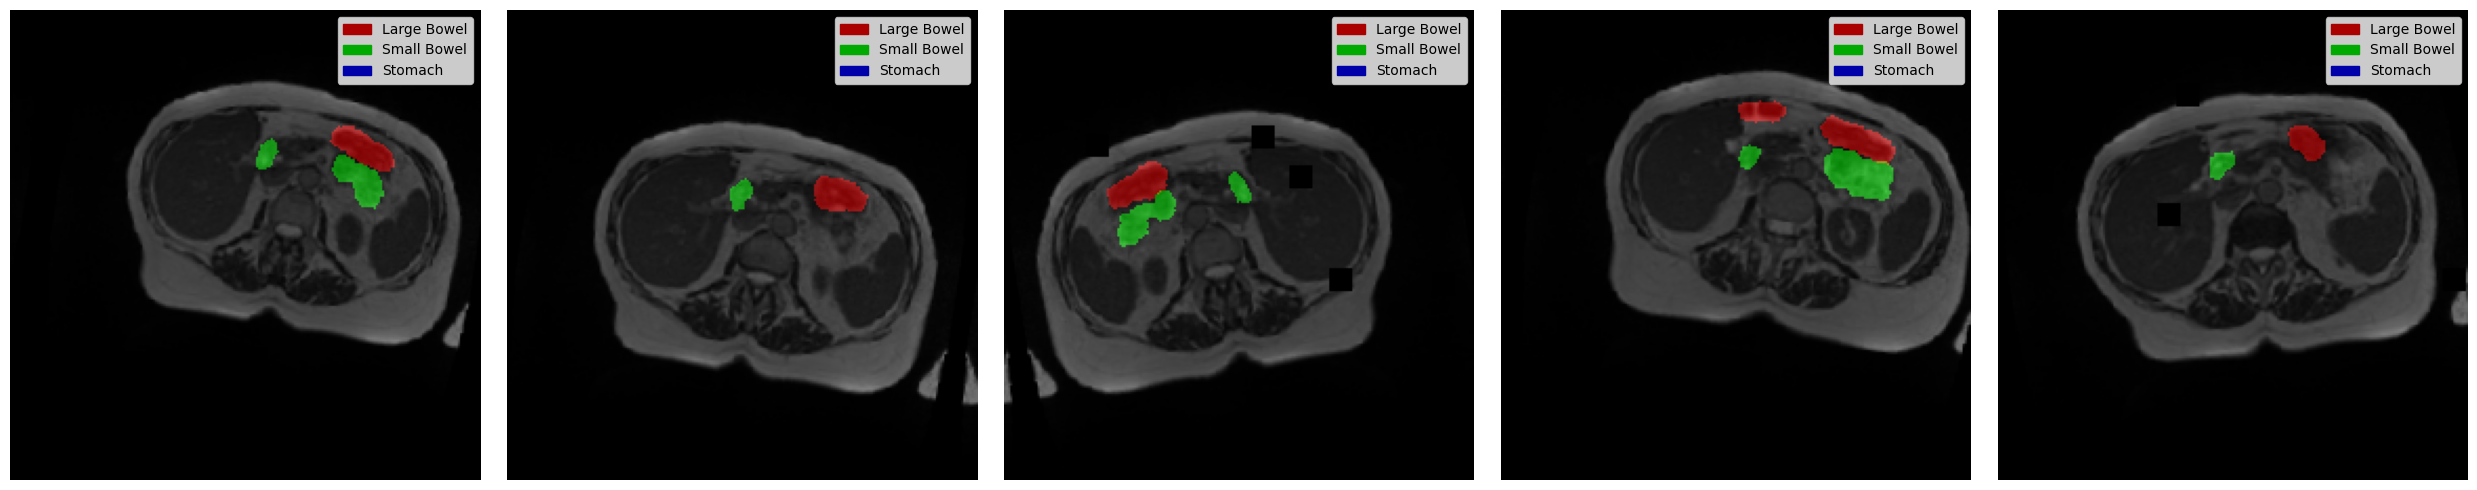

In [20]:
def visualize_images_with_masks(images, masks, number_to_display=5):
    plt.figure(figsize=(number_to_display * 5, 5))
    for idx in range(number_to_display):
        plt.subplot(1, number_to_display, idx + 1)
        
        image = images[idx].permute((1, 2, 0)).numpy() * 255.0
        image = image.astype('uint8')
        mask = masks[idx].permute((1, 2, 0)).numpy() * 255.0
        
        plt.imshow(image, cmap='bone')    
        plt.imshow(mask, alpha=0.5)         
        
        colors = [(0.667, 0, 0), (0, 0.667, 0), (0, 0, 0.667)]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        handles = [Rectangle((0, 0), 1, 1, color=color) for color in colors]
        plt.legend(handles, labels)
        
        plt.axis('off') 
    plt.tight_layout()  
    plt.show()

visualize_images_with_masks(imgs, msks, num=5)

In [21]:
import gc
gc.collect()

12273

## Model


In [22]:
def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      
        encoder_weights="imagenet",     
        in_channels=3,                  
        classes=CFG.num_classes,        
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

## Loss Function

In [23]:
def criterion(y_pred, y_true):
    BCELoss = smp.losses.SoftBCEWithLogitsLoss()(y_pred, y_true)
    TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)
    return 0.5*BCELoss + 0.5*TverskyLoss

def dice_loss(y_pred, y_true):
    smooth = 1e-6
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice  

def criterion_dice_loss(y_pred, y_true):
    BCELoss = F.binary_cross_entropy_with_logits(y_pred, y_true)
    DiceLoss = dice_loss(torch.sigmoid(y_pred), y_true)
    return 0.5 * BCELoss + 0.5 * DiceLoss

In [24]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, n_accumulate, criterion):
    model.train()
    scaler = amp.GradScaler()
    total_loss = 0.0
    total_samples = 0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch} [TRAIN]", leave=False)
    for step, (images, masks) in progress_bar:
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)

        with amp.autocast(enabled=True):
            predictions = model(images)
            loss = criterion_dice_loss(predictions, masks)
            loss /= n_accumulate

        scaler.scale(loss).backward()

        if (step + 1) % n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            if scheduler:
                scheduler.step()

        total_loss += loss.item() * batch_size
        total_samples += batch_size

        epoch_loss = total_loss / total_samples
        mem_reserved = torch.cuda.memory_reserved(device=device) / 1E9
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar.set_postfix(loss=f"{epoch_loss:.4f}", lr=f"{current_lr:.5f}", gpu_mem=f"{mem_reserved:.2f} GB")

    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss

In [25]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch, criterion_dice_loss, dice_coef, iou_coef, optimizer):
    model.eval()
    torch.cuda.empty_cache()

    dataset_size = 0
    running_loss = 0.0

    val_scores = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)

        batch_size = images.size(0)

        y_pred = model(images)
        loss = criterion_dice_loss(y_pred, masks)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_iou = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_iou])

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpu_memory=f'{mem:0.2f} GB')

    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, val_scores

In [26]:
def run_training(model, optimizer, scheduler, device, num_epochs, train_loader, valid_loader, fold):
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice = -np.inf
    best_epoch = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, train_loader, device, epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, device, epoch)
        val_dice, val_iou = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid IOU'].append(val_iou)
        
        wandb.log({"Train Loss": train_loss, "Valid Loss": val_loss, "Valid Dice": val_dice, "Valid IOU": val_iou, "LR": scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:.4f} | Valid IOU: {val_iou:.4f}')
        
        if val_dice >= best_dice:
            best_dice = val_dice
            best_iou = val_iou
            best_epoch = epoch
            wandb.run.summary.update({"Best Dice": best_dice, "Best IOU": best_iou, "Best Epoch": best_epoch})
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f"best_epoch-{fold:02d}.bin")
            wandb.save(f"best_epoch-{fold:02d}.bin")
            print(f"Model Saved")
            
        torch.save(model.state_dict(), f"last_epoch-{fold:02d}.bin")
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(max(best_iou, best_dice)))
    
    model.load_state_dict(best_model_wts)
    
    return model, history

# Build Dice, IOU function

In [27]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2, 3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = (2 * inter + epsilon) / (den + epsilon)
    return dice.mean(dim=(1, 0))

def iou_coef(y_true, y_pred, thr=0.5, dim=(2, 3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true * y_pred).sum(dim=dim)
    iou = (inter + epsilon) / (union + epsilon)
    return iou.mean(dim=(1, 0))

In [29]:
fold = 4
run = wandb.init(project="UNET_Surya", 
                 config={k: v for k, v in dict(vars(CFG)).items() if '__' not in k},
                 name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}"
                )

train_loader, valid_loader = create_data_loaders(fold=fold, debug=CFG.debug)

model = build_model()

optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, eta_min=CFG.min_lr)

model, history = run_training(model, optimizer, scheduler,
                              device=CFG.device,
                              num_epochs=CFG.epochs,
                              train_loader=train_loader,
                              valid_loader=valid_loader,
                              fold=fold)

run.finish()

cuda: Tesla T4

Epoch 1/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.02it/s, gpu_memory=2.90 GB, lr=0.00131, valid_loss=0.2763]


Valid Dice: 0.6320 | Valid IOU: 0.5985
Model Saved
Epoch 2/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.00it/s, gpu_memory=2.90 GB, lr=0.00019, valid_loss=0.1357]


Valid Dice: 0.8579 | Valid IOU: 0.8241
Model Saved
Epoch 3/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.06it/s, gpu_memory=2.95 GB, lr=0.00181, valid_loss=0.1223]


Valid Dice: 0.8701 | Valid IOU: 0.8375
Model Saved
Epoch 4/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.05it/s, gpu_memory=2.96 GB, lr=0.00069, valid_loss=0.1174]


Valid Dice: 0.8772 | Valid IOU: 0.8456
Model Saved
Epoch 5/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.03it/s, gpu_memory=2.91 GB, lr=0.00200, valid_loss=0.1147]


Valid Dice: 0.8827 | Valid IOU: 0.8512
Model Saved
Epoch 6/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.06it/s, gpu_memory=2.95 GB, lr=0.00131, valid_loss=0.1161]


Valid Dice: 0.8700 | Valid IOU: 0.8379
Epoch 7/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.05it/s, gpu_memory=2.96 GB, lr=0.00019, valid_loss=0.1187]


Valid Dice: 0.8651 | Valid IOU: 0.8342
Epoch 8/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.05it/s, gpu_memory=2.96 GB, lr=0.00181, valid_loss=0.1097]


Valid Dice: 0.8909 | Valid IOU: 0.8604
Model Saved
Epoch 9/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.05it/s, gpu_memory=2.96 GB, lr=0.00069, valid_loss=0.1144]


Valid Dice: 0.8864 | Valid IOU: 0.8561
Epoch 10/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.06it/s, gpu_memory=2.91 GB, lr=0.00200, valid_loss=0.1107]


Valid Dice: 0.8889 | Valid IOU: 0.8586
Epoch 11/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.07it/s, gpu_memory=2.96 GB, lr=0.00131, valid_loss=0.1104]


Valid Dice: 0.8844 | Valid IOU: 0.8541
Epoch 12/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.07it/s, gpu_memory=2.91 GB, lr=0.00019, valid_loss=0.1102]


Valid Dice: 0.8835 | Valid IOU: 0.8531
Epoch 13/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.03it/s, gpu_memory=2.96 GB, lr=0.00181, valid_loss=0.1142]


Valid Dice: 0.8804 | Valid IOU: 0.8489
Epoch 14/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.06it/s, gpu_memory=2.92 GB, lr=0.00069, valid_loss=0.1134]


Valid Dice: 0.8942 | Valid IOU: 0.8645
Model Saved
Epoch 15/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.05it/s, gpu_memory=2.96 GB, lr=0.00200, valid_loss=0.1127]


Valid Dice: 0.8893 | Valid IOU: 0.8596
Epoch 16/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.07it/s, gpu_memory=2.96 GB, lr=0.00131, valid_loss=0.1106]


Valid Dice: 0.8800 | Valid IOU: 0.8494
Epoch 17/25

Valid : 100%|██████████| 117/117 [00:37<00:00,  3.08it/s, gpu_memory=2.96 GB, lr=0.00019, valid_loss=0.1079]


Valid Dice: 0.8824 | Valid IOU: 0.8523
Epoch 18/25

Valid : 100%|██████████| 117/117 [00:37<00:00,  3.09it/s, gpu_memory=2.96 GB, lr=0.00181, valid_loss=0.1109]


Valid Dice: 0.8825 | Valid IOU: 0.8516
Epoch 19/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.06it/s, gpu_memory=2.96 GB, lr=0.00069, valid_loss=0.1096]


Valid Dice: 0.8905 | Valid IOU: 0.8611
Epoch 20/25

Valid : 100%|██████████| 117/117 [00:37<00:00,  3.10it/s, gpu_memory=2.96 GB, lr=0.00200, valid_loss=0.1040]


Valid Dice: 0.8898 | Valid IOU: 0.8600
Epoch 21/25

Valid : 100%|██████████| 117/117 [00:37<00:00,  3.09it/s, gpu_memory=2.96 GB, lr=0.00131, valid_loss=0.1082]


Valid Dice: 0.8838 | Valid IOU: 0.8533
Epoch 22/25

Valid : 100%|██████████| 117/117 [00:38<00:00,  3.08it/s, gpu_memory=2.96 GB, lr=0.00019, valid_loss=0.1072]


Valid Dice: 0.8913 | Valid IOU: 0.8611
Epoch 23/25

Valid : 100%|██████████| 117/117 [00:37<00:00,  3.09it/s, gpu_memory=2.96 GB, lr=0.00181, valid_loss=0.1159]


Valid Dice: 0.8875 | Valid IOU: 0.8585
Epoch 24/25

Valid : 100%|██████████| 117/117 [00:37<00:00,  3.09it/s, gpu_memory=2.96 GB, lr=0.00069, valid_loss=0.1058]


Valid Dice: 0.8909 | Valid IOU: 0.8609
Epoch 25/25

Valid : 100%|██████████| 117/117 [00:37<00:00,  3.09it/s, gpu_memory=2.96 GB, lr=0.00200, valid_loss=0.1090]


Valid Dice: 0.8863 | Valid IOU: 0.8558
Training complete in 2h 44m 51s
Best Score: 0.8942


LR,▅▁▇▃█▅▁▇▃█▅▁▇▃█▅▁▇▃█▅▁▇▃█
Train Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Dice,▁▇▇██▇▇██████████████████
Valid IOU,▁▇▇██▇▇██████████████████
Valid Loss,█▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Best Dice,0.89417
Best Epoch,14
Best IOU,0.86455
LR,0.002
Train Loss,0.08489
Valid Dice,0.88627


# Prediction

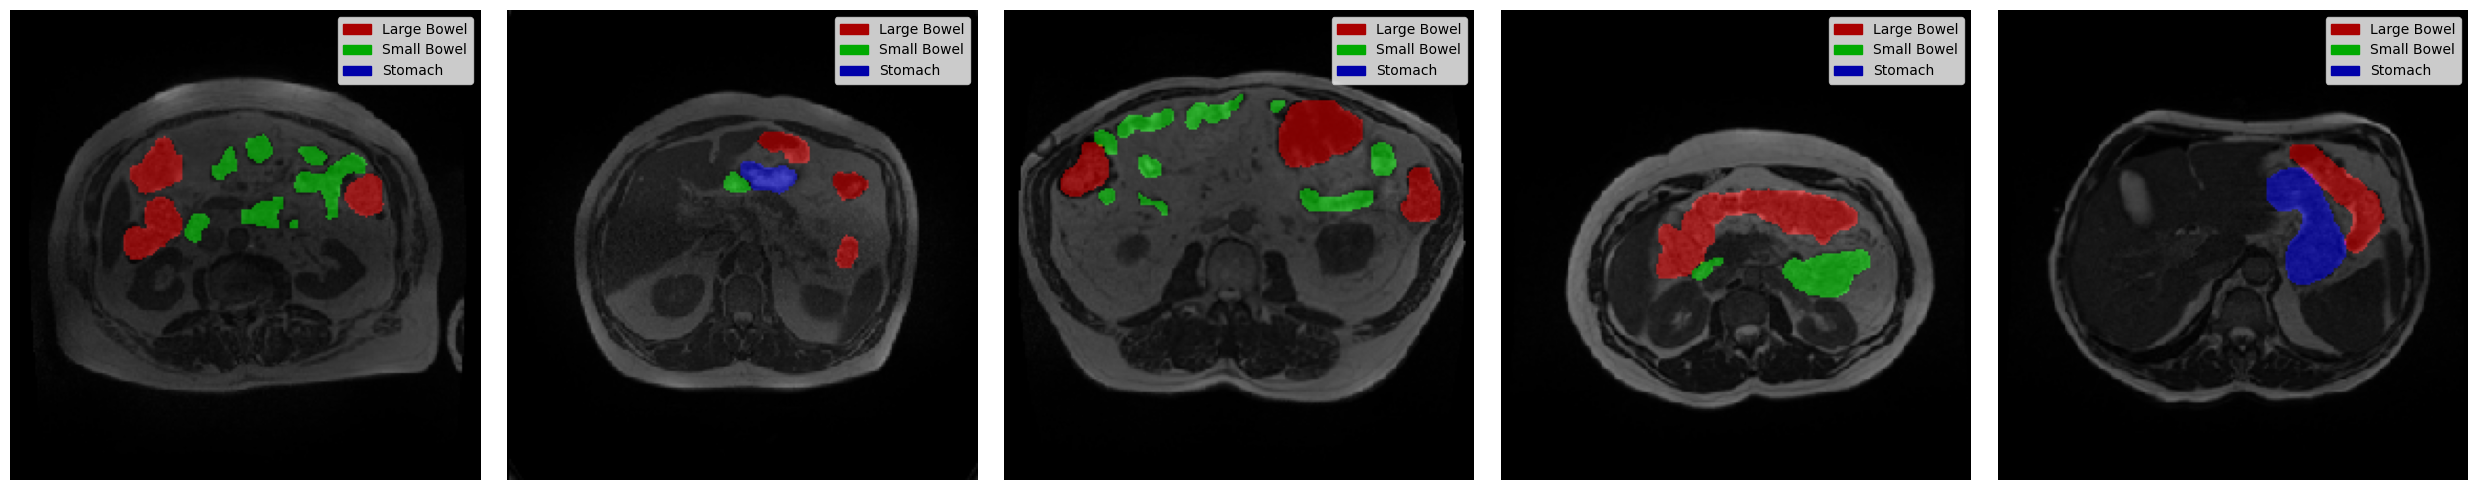

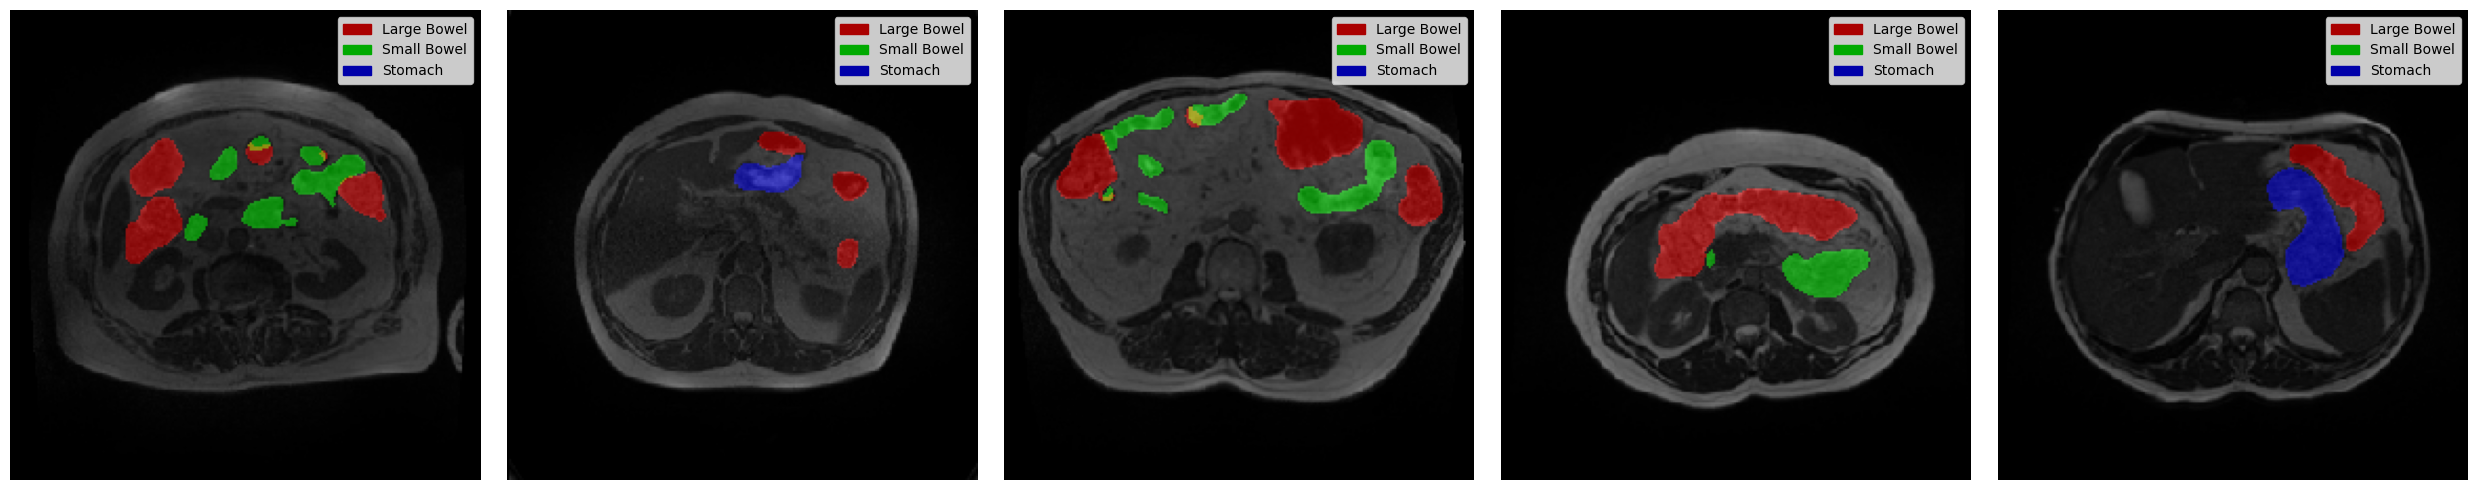

In [30]:
test_dataset = DatasetBuilder(df.query("fold==@fold & segmentation==True").sample(frac=1.0), label=True, transforms=data_transforms['valid'])
test_loader = DataLoader(test_dataset, batch_size=5, num_workers=4, shuffle=False, pin_memory=True)

imgs, msks = next(iter(test_loader))
visualize_images_with_masks(imgs, msks)

model = load_model(f"last_epoch-{fold:02d}.bin").to(CFG.device)

preds = []
with torch.no_grad():
    imgs = imgs.to(CFG.device, dtype=torch.float)
    pred = model(imgs)
    pred = (nn.Sigmoid()(pred) > 0.5).double()
    preds.append(pred)

imgs = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

visualize_images_with_masks(imgs, preds)